In [1]:
import diff_classifier.aws as aws
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.imagej as ij
import diff_classifier.heatmaps as hm
import os
import os.path as op
import numpy as np
import numpy.ma as ma
import pandas as pd
import boto3
import skimage.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and checking a video

In [ ]:
test_image = sio.imread('P1_S1_R_0000_3_3.tif')

In [ ]:
sio.imshow(test_image[650, :, :], cmap='gray', vmin=60, vmax=250)

In [ ]:
sio.imshow(test_image[0, :, :], cmap='gray', vmin=60, vmax=250)

# Splitting images before analysis

In [2]:
prefix = 'P3_S3_R_0000'
remote_folder = "01_18_Experiment/{}".format(prefix.split('_')[0])
local_folder = os.getcwd()
ires = 512
frames = 651
filename = '{}.tif'.format(prefix)
remote_name = op.join(remote_folder, filename)
local_name = op.join(local_folder, filename)

s3 = boto3.client('s3')

In [ ]:
remote_folder+'/'+name

In [ ]:
ij.partition_im?

In [ ]:
names = []
for i in range(0, 4):
    for j in range(0, 4):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))

try:
    for name in names:
        aws.download_s3(remote_folder+'/'+name, name)
except:
    aws.download_s3(remote_name, local_name)
    names = ij.partition_im(local_name)
    for name in names:
        #aws.upload_s3(name, op.join(remote_folder, name))
        print("Done with splitting.  Should output file of name {}".format(remote_folder+'/'+name))

# Particle Tracking

Pause here to demonstrate tracking with the Trackmate GUI.  Show the Trackmate template file.

In [ ]:
ij.track?

In [ ]:
outfile = 'Traj_' + name[0].split('.')[0] + '.csv'
local_im = op.join(local_folder, name)

test_intensity = ij.mean_intensity(local_im)
if test_intensity > 500:
    quality = 245
else:
    quality = 4.5

ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
      do_median_filtering=True, quality=quality, x=511, y=511, median_intensity=300.0, snr=0.0, 
      linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
      track_displacement=10.0)

In [ ]:
for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = op.join(local_folder, name)

#     try:
#         aws.download_s3(remote_folder+'/'+outfile, outfile)
#     except:
    test_intensity = ij.mean_intensity(local_im)
    if test_intensity > 500:
        quality = 245
    else:
        quality = 4.5

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
          do_median_filtering=True, quality=quality, x=511, y=511, median_intensity=300.0, snr=0.0, 
          linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
          track_displacement=10.0)

    aws.upload_s3(outfile, remote_folder+'/'+outfile)
    print("Done with tracking.  Should output file of name {}".format(remote_folder+'/'+outfile))

# Calculating MSDs and Features

In [ ]:
msd.all_msds2?

In [ ]:
filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
local_name = local_folder+'/'+filename

merged = msd.all_msds2(ut.csv_to_pd(local_name), frames=frames)

In [ ]:
merged

In [ ]:
merged_ft = ft.calculated_features(merged)

In [ ]:
merged_ft

In [ ]:
msd_file = 'msd_{}.csv'.format(prefix)
ft_file = 'features_{}.csv'.format(prefix)

counter = 0
for name in names:
    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

    filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
    local_name = local_folder+'/'+filename

    if counter == 0:
        to_add = ut.csv_to_pd(local_name)
        to_add['X'] = to_add['X'] + ires*row
        to_add['Y'] = to_add['Y'] + ires*row
        merged = msd.all_msds2(to_add, frames=frames)
    else: 

        if merged.shape[0] > 0:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*row
            to_add['Y'] = to_add['Y'] + ires*col
            to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
        else:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*row
            to_add['Y'] = to_add['Y'] + ires*col
            to_add['Track_ID'] = to_add['Track_ID']

        merged = merged.append(msd.all_msds2(to_add, frames=frames))
    counter = counter + 1

merged.to_csv(msd_file)
aws.upload_s3(msd_file, remote_folder+'/'+msd_file)
merged_ft = ft.calculate_features(merged)
merged_ft.to_csv(ft_file)
aws.upload_s3(ft_file, remote_folder+'/'+ft_file)

# Trajectory Visualization

In [9]:
merged = pd.read_csv('msd_{}.csv'.format(prefix))

In [ ]:
#merged[merged['X']==512]
merged[merged['Track_ID']==313][merged['X']>0]

In [ ]:
merged[(merged['Track_ID']==1538) & (merged['X']>0)]

In [ ]:
merged[merged['Y']>2000][1000:1500]

Plotted P3_S3_R_0000 trajectories successfully.


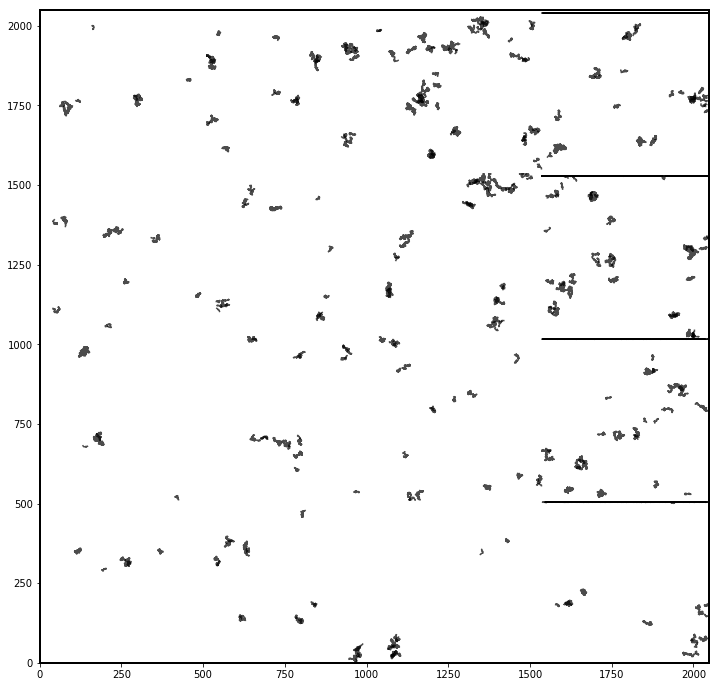

In [7]:
hm.plot_trajectories(prefix)

Plotted P3_S3_R_0000 heatmap successfully.


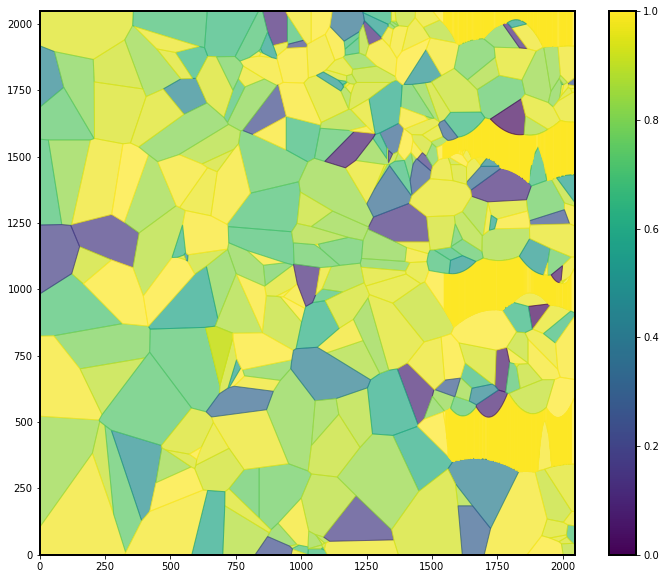

In [6]:
hm.plot_heatmap(prefix)

In [ ]:
hm.plot_scatterplot(prefix)

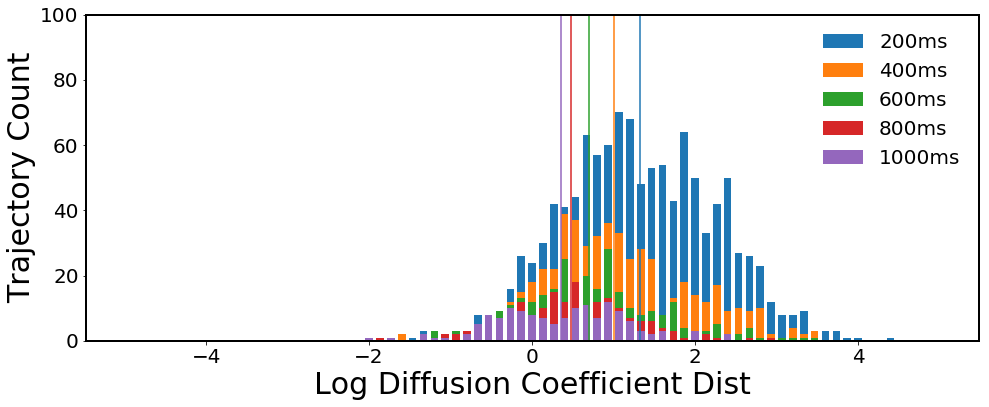

In [3]:
hm.plot_histogram(prefix)

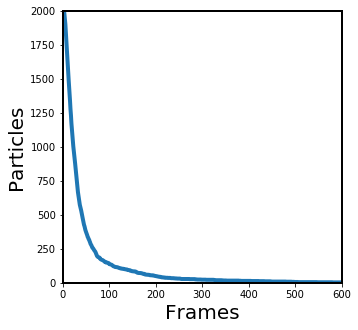

In [5]:
hm.plot_particles_in_frame(prefix)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


(0, 20)

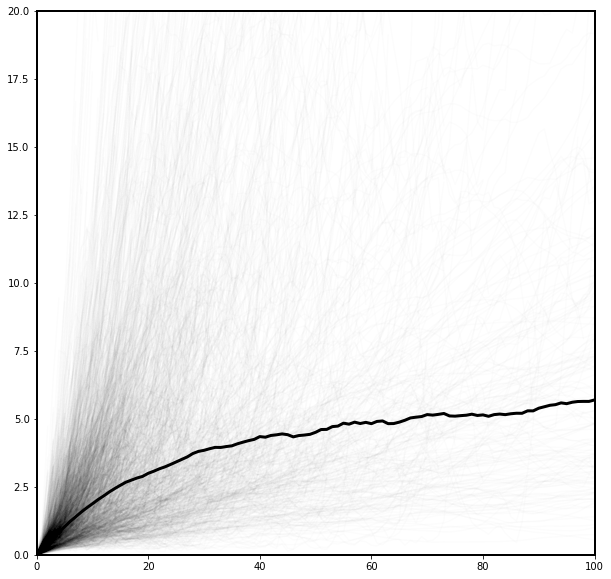

In [29]:
umppx = 0.16

fig = plt.figure(figsize=(10, 10))
particles = int(max(merged['Track_ID']))
frames = int(max(merged['Frame']))
y = np.zeros((particles+1, frames+1))
for i in range(0, particles+1):
    y[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
    x = merged.loc[merged.Track_ID == i, 'Frame']
    plt.plot(x, y[i, :], 'k', alpha=0.01)

geo_mean = np.exp(np.nanmean(np.log(y), axis=0))
plt.plot(x, geo_mean, 'k', linewidth=3)
plt.xlim(0, 100)
plt.ylim(0, 20)

In [24]:
geo_mean = np.exp(np.nanmean(np.log(y), axis=0)).shape

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(651,)

In [27]:
geo_mean

(651,)